# Lab time series analysis: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

In [1]:
# Package imports for data science and time series analysis in particular
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd;
import scipy.stats as stats;
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index:

In [2]:
covid19 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date']).set_index(['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

<Axes: title={'center': 'Belgium: New cases and new deaths per day'}, xlabel='date'>

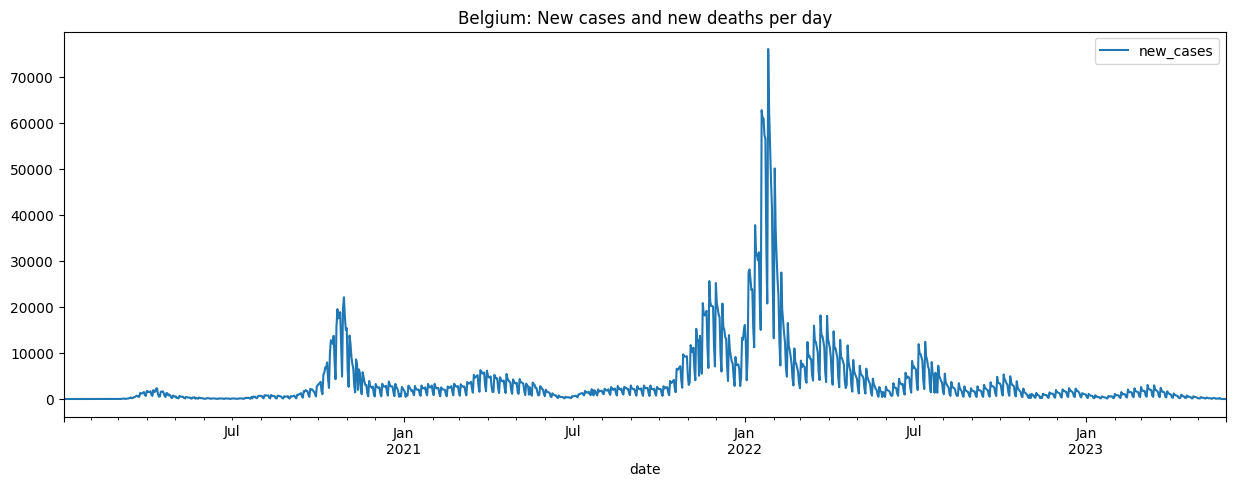

In [3]:
covid19_be = covid19[covid19['location'] == 'Belgium'][['new_cases']]
covid19_be.plot(y=['new_cases'], figsize=(15, 5), title='Belgium: New cases and new deaths per day')

## Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

<Axes: title={'center': 'Belgium: New cases per day and 7-day and 30-day moving averages'}, xlabel='date'>

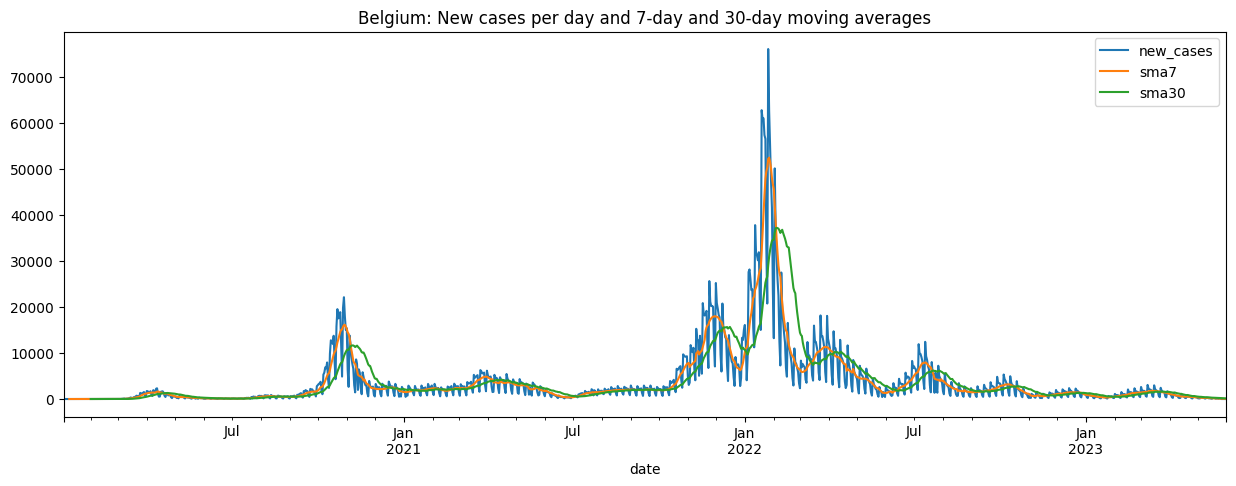

In [4]:
covid19_be['sma7'] = covid19_be['new_cases'].rolling(7).mean()
covid19_be['sma30'] = covid19_be['new_cases'].rolling(30).mean()

covid19_be.plot(y=['new_cases', 'sma7', 'sma30'], figsize=(15, 5), title='Belgium: New cases per day and 7-day and 30-day moving averages')

## Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

<Axes: title={'center': 'Belgium: New cases per day and 7-day and 30-day moving averages'}, xlabel='date'>

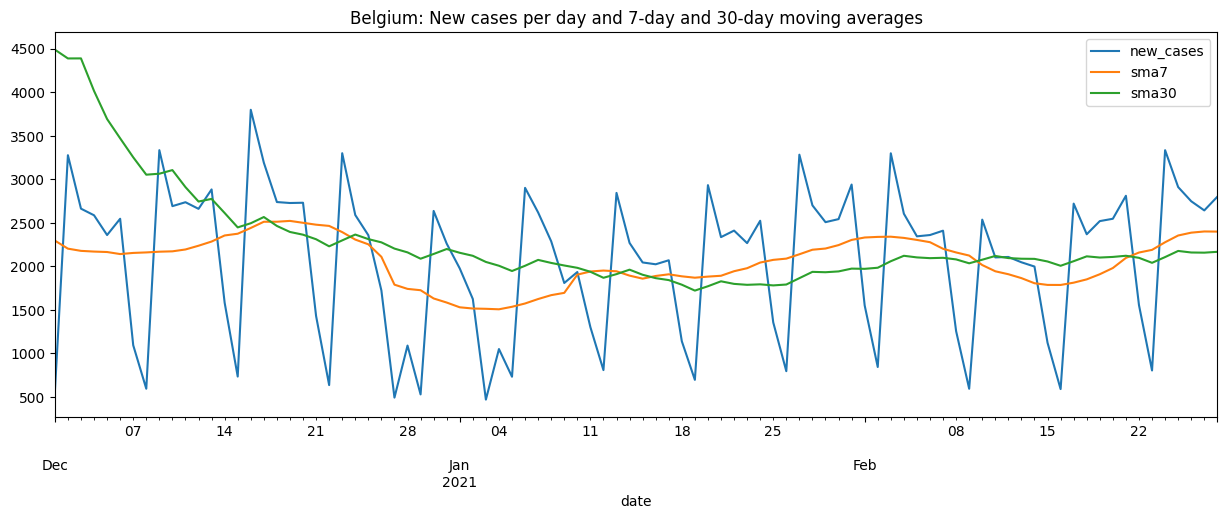

In [5]:
period_1 = covid19_be[(covid19_be.index >= '2020-12-01') & (covid19_be.index <= '2021-02-28')]
period_1.plot(y=['new_cases', 'sma7', 'sma30'], figsize=(15, 5), title='Belgium: New cases per day and 7-day and 30-day moving averages')



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

<Axes: xlabel='date'>

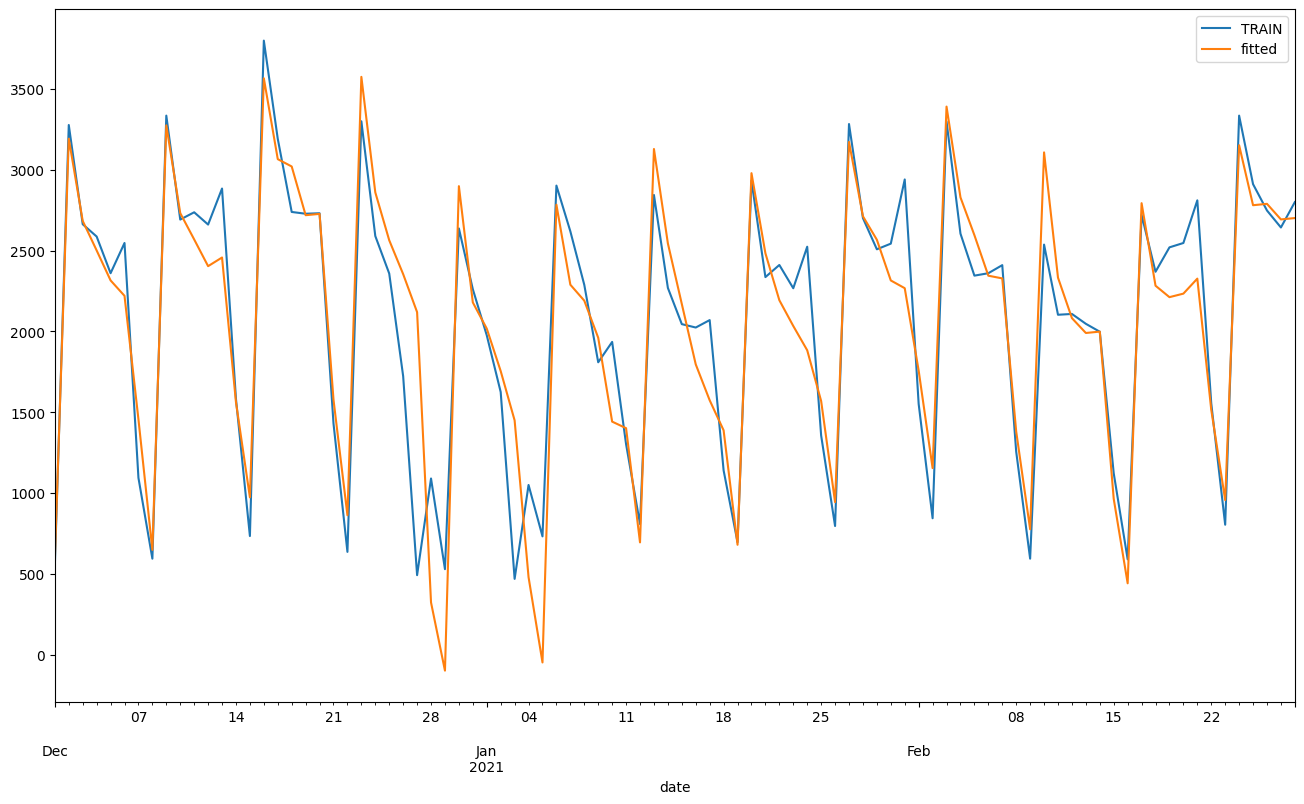

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = period_1.new_cases
model = ExponentialSmoothing(train,
                             trend='add', 
                             seasonal='add', 
                             seasonal_periods=7, 
                             freq='D').fit()

train.plot(legend=True, label='TRAIN', figsize=(16, 9))
model.fittedvalues.plot(legend=True, label='fitted')

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

Text(0.5, 1.0, 'Train, test, fitted & predicted values using Holt-Winters')

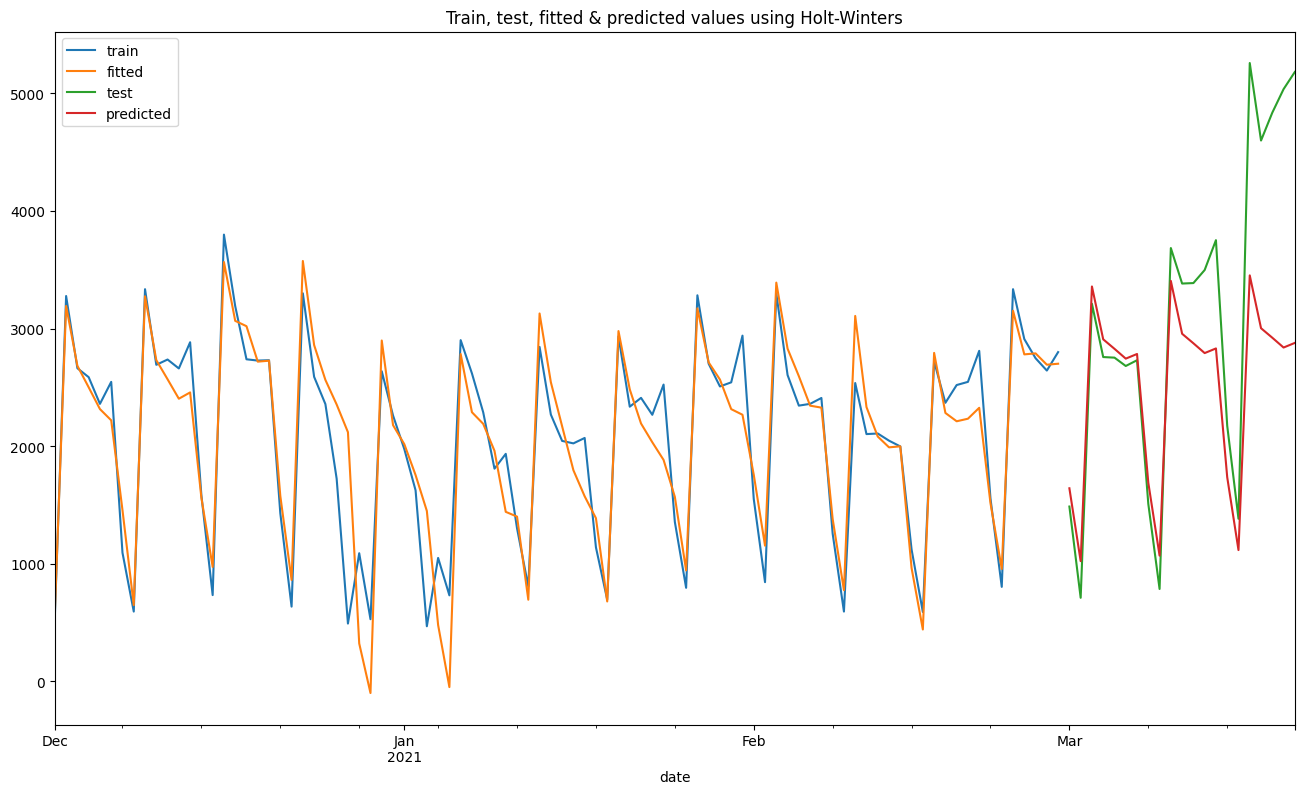

In [7]:
forecast = model.forecast(21)

train.plot(legend=True, label='train')
model.fittedvalues.plot(legend=True, label='fitted')

test = covid19_be[(covid19_be.index >= '2021-03-01') & (covid19_be.index <= '2021-03-21')].new_cases
test.plot(legend=True, label='test')
forecast.plot(legend=True, label='predicted', figsize=(16, 9))

plt.title('Train, test, fitted & predicted values using Holt-Winters')

## Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   25408.902 |  159.402 |  855.684 |
| 2021-03-01 to 2021-03-14 |  154280.817 |  392.786 |  895.531 |
| 2021-03-01 to 2021-03-21 | 1048835.781 | 1024.127 | 1052.978 |

In [8]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test[0:7],forecast[0:7])}')
print(f'MSE = {mean_squared_error(test[0:7],forecast[0:7])}')
print(f"√MSE = {np.sqrt(mean_squared_error(test[0:7],forecast[0:7]))}")

tmp = pd.concat([test[0:7],forecast[0:7]])
print(f"stdev = {np.std(tmp, ddof=1)}")

MAE = 136.4480975857061
MSE = 25408.90161016752
√MSE = 159.40169889360502
stdev = 826.6446255952336


In [9]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test[0:14],forecast[0:14])}')
print(f'MSE = {mean_squared_error(test[0:14],forecast[0:14])}')
print(f"√MSE = {np.sqrt(mean_squared_error(test[0:14],forecast[0:14]))}")

tmp = pd.concat([test[0:14],forecast[0:14]])
print(f"stdev = {np.std(tmp, ddof=1)}")

MAE = 304.5734169631971
MSE = 154280.81707120585
√MSE = 392.78596852637935
stdev = 912.5043994465636


In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

print(f'MAE = {mean_absolute_error(test[0:21],forecast[0:21])}')
print(f'MSE = {mean_squared_error(test[0:21],forecast[0:21])}')
print(f"√MSE = {np.sqrt(mean_squared_error(test[0:21],forecast[0:21]))}")

tmp = pd.concat([test[0:21],forecast[0:21]])
print(f"stdev = {np.std(tmp, ddof=1)}")

MAE = 703.9785959620805
MSE = 1048835.7806246676
√MSE = 1024.1268381527102
stdev = 1160.9772919255886


## ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

<Axes: xlabel='date'>

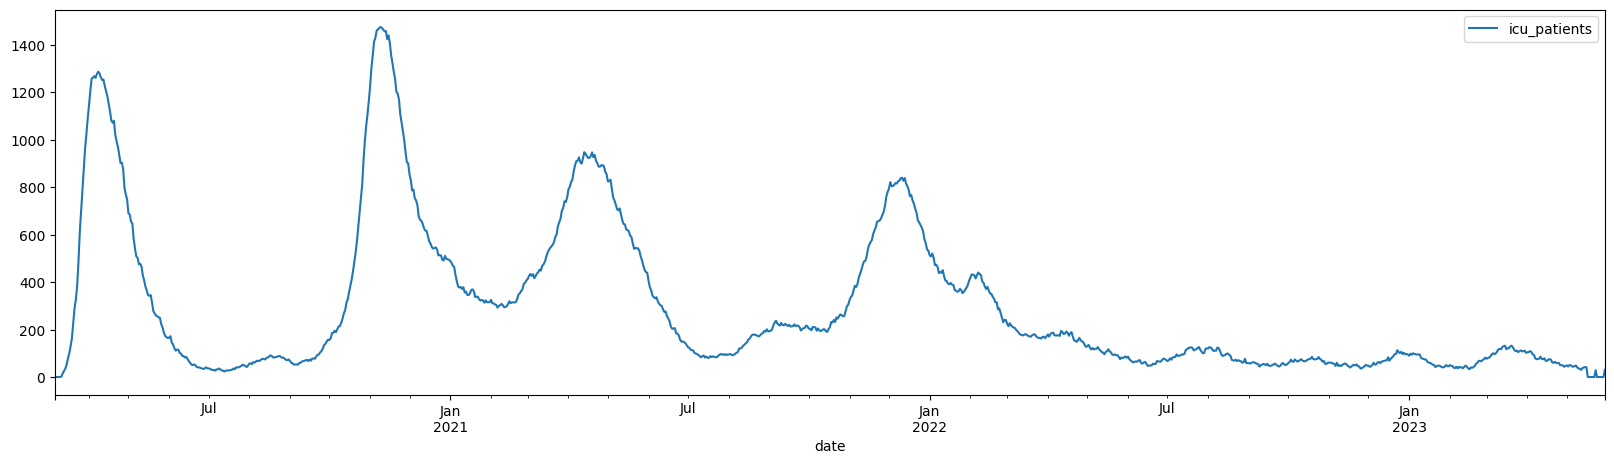

In [11]:
covid19_be_icu = covid19[covid19['location'] == 'Belgium'][['icu_patients']].dropna()
covid19_be_icu.plot(figsize=(20,5))

Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

/home/anton/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='date'>

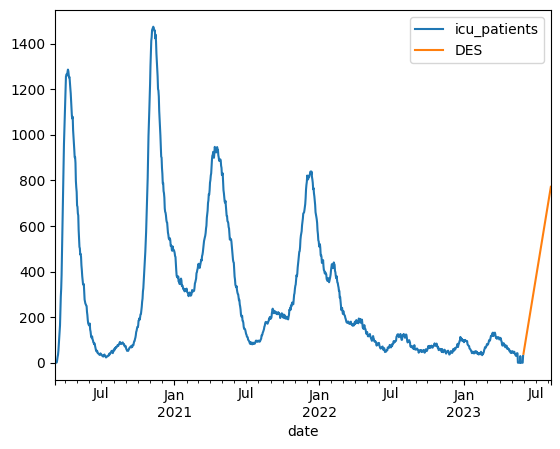

In [19]:
from statsmodels.tsa.api import Holt

data_des = Holt(covid19_be_icu.icu_patients).fit()
df_des_fcast = data_des.forecast(70)

covid19_be_icu['DES'] = data_des.fittedvalues

covid19_be_icu.icu_patients.plot(legend=True)
df_des_fcast.plot(legend=True, label='DES')

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

-   Current trend: **downward**
-   Forecasted values: **not reasonable**, as the number of IC patients is increasing sharply.

Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

<Axes: xlabel='date'>

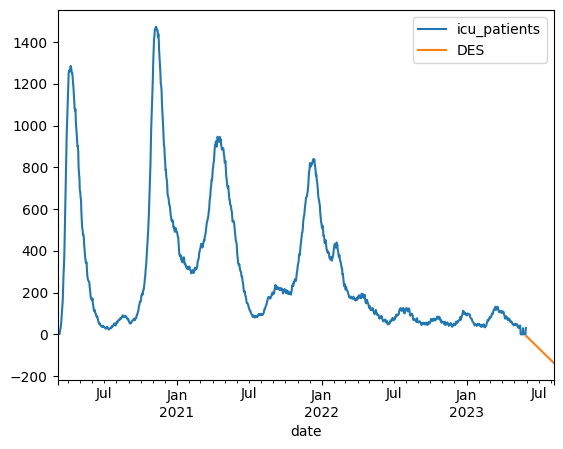

In [24]:
from statsmodels.tsa.api import Holt

data_des = Holt(covid19_be_icu.icu_patients).fit(smoothing_level=.1, smoothing_trend=.2)
df_des_fcast = data_des.forecast(70)

covid19_be_icu['DES'] = data_des.fittedvalues

covid19_be_icu.icu_patients.plot(legend=True)
df_des_fcast.plot(legend=True, label='DES')

What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

<Axes: xlabel='date'>

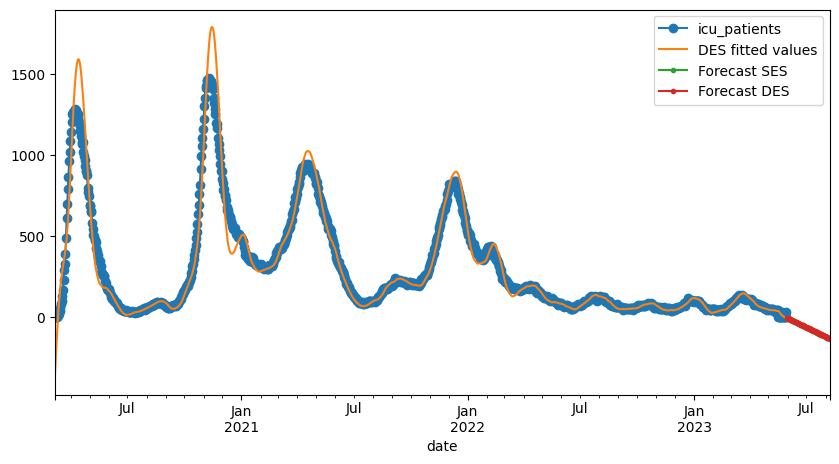

In [22]:
covid19_be_icu['icu_patients'].plot(marker='o', legend=True)
covid19_be_icu['DES'].plot(legend=True, label='DES fitted values', figsize=[10,5])
df_des_fcast.plot(marker='.', legend=True, label='Forecast SES')
df_des_fcast.plot(marker='.', legend=True, label='Forecast DES')

Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

<Axes: xlabel='date'>

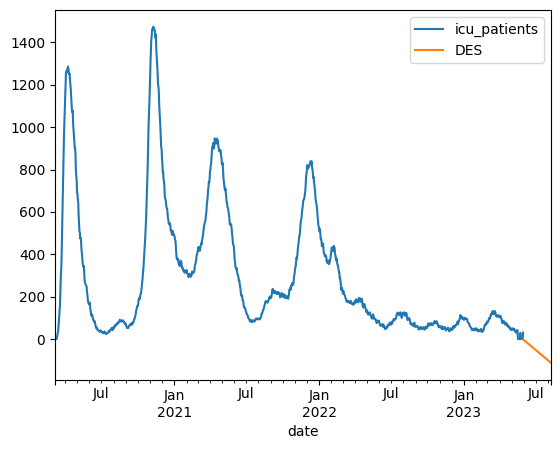

In [25]:
from statsmodels.tsa.api import Holt

data_des = Holt(covid19_be_icu.icu_patients).fit(smoothing_level=.1, smoothing_trend=.1)
df_des_fcast = data_des.forecast(70)

covid19_be_icu['DES'] = data_des.fittedvalues

covid19_be_icu.icu_patients.plot(legend=True)
df_des_fcast.plot(legend=True, label='DES')

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?

The last two forecast models seem to perform the best out of the three. The first model (with the default parameters) is too unrealistic, as it predicts a sharp increase in the number of IC patients. The second model (with $\alpha = 0.1$ and $\beta = 0.2$) is more realistic, as it predicts a more gradual decrease in the number of IC patients. The last model (with $\alpha = \beta = 0.1$) is also realistic, as it predicts a gradual decrease in the number of IC patients.